In [1]:
!export CUDA_VISIBLE_DEVICES='6'

In [2]:

from __future__ import print_function

import os
import sys
import argparse
import time
import math
import matplotlib.pyplot as plt

import tensorboard_logger as tb_logger
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

from util import TwoCropTransform, AverageMeter
from util import adjust_learning_rate, warmup_learning_rate
from util import set_optimizer, save_model
from networks.resnet_big import SupConResNet
from losses import SupConLoss


In [3]:
# construct data loader
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])

train_dataset = datasets.CIFAR10(root="../datasets/",
                                        transform=TwoCropTransform(train_transform),
                                        download=True)
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=(train_sampler is None),
    num_workers=16, pin_memory=True, sampler=train_sampler)
del train_dataset, train_sampler


Files already downloaded and verified


In [4]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


AttributeError: 'list' object has no attribute 'size'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

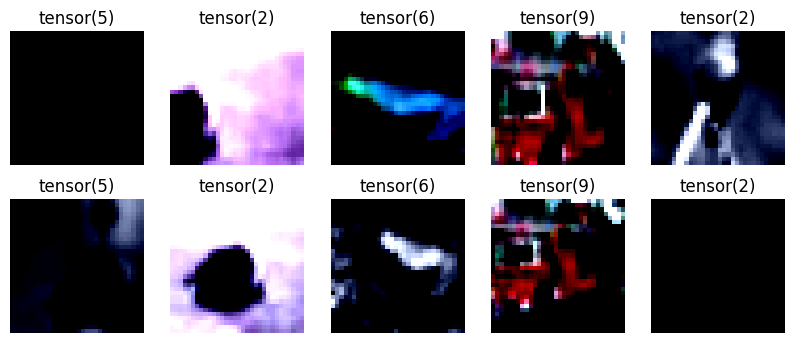

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

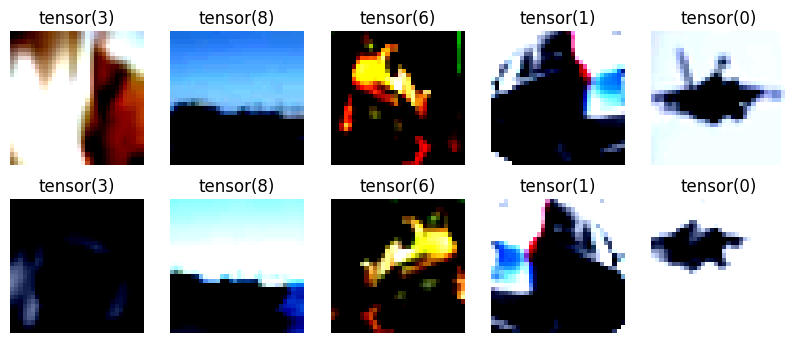

In [57]:
for idx, (images, labels) in enumerate(train_loader):
    # plot first 10 images
    if idx == 2:
        break
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(5):
        ax = axes[0,i%5]
        ax = axes[0,i%5]
        img = images[0][i].squeeze().permute(1, 2, 0)
        label = labels[i]
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")

        ax = axes[1,i%5]
        img = images[1][i].squeeze().permute(1, 2, 0)
        label = labels[i]
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")
    plt.show()



In [44]:
from torch.utils.data import Dataset
import numpy as np
class ImageDataset(Dataset):
    def __init__(self, images, targets,transform_train, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transform_train
        # self.transform_train = TwoCropTransform(transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.RandomCrop((crop_size, crop_size), padding=None),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.Resize((image_size, image_size)),
        # ]))
        self.transform_test = TwoCropTransform(transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
        ]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target


In [55]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])
from libauc.datasets import CAT_VS_DOG, CIFAR10, CIFAR100
from PIL import Image
from torch.utils.data import Dataset
from libauc.utils import ImbalancedDataGenerator #BUG:  this is using import from conda install
SEED=123
imratio=0.5
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
train_data, train_targets = CIFAR10(root="../datasets/")

generator = ImbalancedDataGenerator(verbose=True, random_seed=SEED)
(train_images, train_labels) = generator.transform(
    train_data, train_targets, imratio=imratio)
    
train_sampler = None
train_loader2 = torch.utils.data.DataLoader(ImageDataset(
train_images, train_labels,TwoCropTransform(train_transform)), batch_size=256, shuffle=(train_sampler is None), num_workers=16, pin_memory=True, sampler=train_sampler)

# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
#     num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)


Files already downloaded and verified
#SAMPLES: [50000], POS:NEG: [25000 : 25000], POS RATIO: 0.5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

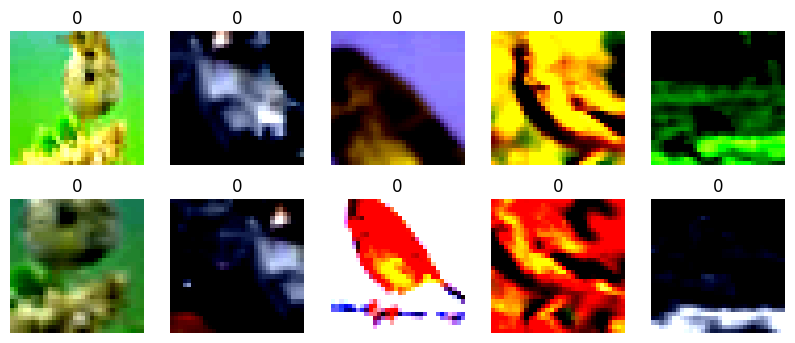

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

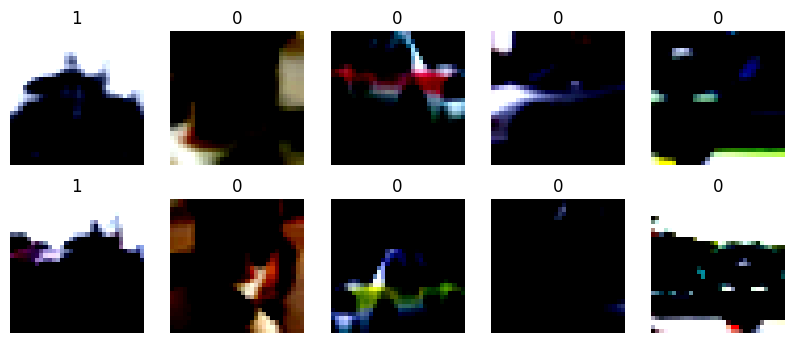

In [56]:
for idx, (images, labels) in enumerate(train_loader2):
    # plot first 10 images
    if idx == 2:
        break
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(5):
        ax = axes[0,i%5]
        ax = axes[0,i%5]
        img = images[0][i].squeeze().permute(1, 2, 0)
        label = labels[i].item()
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")

        ax = axes[1,i%5]
        img = images[1][i].squeeze().permute(1, 2, 0)
        label = labels[i].item()
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")
    plt.show()



In [2]:
from calibration_library.metrics import ECELoss

ECELoss()

In [1]:
from __future__ import print_function

import os
import sys
import argparse
import time
import math

import tensorboard_logger as tb_logger
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

from util import TwoCropTransform, AverageMeter
from util import adjust_learning_rate, warmup_learning_rate
from util import set_optimizer, save_model
from networks.resnet_big import SupConResNet
from losses import SupConLoss
from datasets import set_loader

try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass


def parse_option():
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=200,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=16,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=1000,
                        help='number of training epochs')

    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='700,800,900',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')

    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='cifar10',
                        choices=['cifar10', 'cifar100', 'c2','stl10','path'], help='dataset')
    parser.add_argument('--imratio', type=float, default=0.1,
                        help='imbalance ratio')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=32, help='parameter for RandomResizedCrop')

    # method
    parser.add_argument('--method', type=str, default='SupCon',
                        choices=['SupCon', 'SimCLR'], help='choose method')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')

    # other setting
    parser.add_argument('--cosine', action='store_true',
                        help='using cosine annealing')
    parser.add_argument('--syncBN', action='store_true',
                        help='using synchronized batch normalization')
    parser.add_argument('--warm', action='store_true',
                        help='warm-up for large batch training')
    parser.add_argument('--trial', type=str, default='0',
                        help='id for recording multiple runs')

    opt = parser.parse_args()

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
            and opt.mean is not None \
            and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = '../../data/'
    opt.model_path = './save/SupCon/{}_models'.format(opt.dataset)
    opt.tb_path = './save/SupCon/{}_tensorboard'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_{}_{}_im_{}_lr_{}_decay_{}_bsz_{}_temp_{}_trial_{}'.\
        format(opt.method, opt.dataset, opt.model,opt.imratio, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp, opt.trial)

    if opt.cosine:
        opt.model_name = '{}_cosine'.format(opt.model_name)

    # warm-up for large-batch training,
    if opt.batch_size > 256:
        opt.warm = True
    if opt.warm:
        opt.model_name = '{}_warm'.format(opt.model_name)
        opt.warmup_from = 0.01
        opt.warm_epochs = 10
        if opt.cosine:
            eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
            opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * (
                    1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
        else:
            opt.warmup_to = opt.learning_rate

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt


In [3]:
# opt=parse_option()
train_loader, val_loader= set_loader(opt)

NameError: name 'opt' is not defined